In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow 
from sklearn import metrics

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import  BatchNormalization, Dropout, Flatten, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau

import keras.backend as K

In [37]:
train_data = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_data = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

test_data = ImageDataGenerator(
    rescale = 1./255)

In [38]:
size = (224,224)
class_name = 'categorical'
batch = 32

In [39]:
train_dataset  = train_data.flow_from_directory(
    directory = '..\\Data\\Chest Cancer dataset\\train',
    target_size = size,
    class_mode = class_name,
    batch_size = batch)

Found 613 images belonging to 4 classes.


In [40]:
validation_dataset = valid_data.flow_from_directory(
    directory = '..\\Data\\Chest Cancer dataset\\valid',
    target_size = size,
    class_mode = class_name,
    batch_size = batch)

Found 72 images belonging to 4 classes.


In [41]:
testing_dataset = test_data.flow_from_directory(
    directory = '..\\Data\\Chest Cancer dataset\\test',
    target_size = size,
    class_mode = class_name,
    batch_size = batch)

Found 315 images belonging to 4 classes.


In [42]:
base_model = VGG16(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet")

In [43]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [44]:
model=Sequential()

model.add(base_model)

model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [45]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_score

In [46]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

In [47]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                802848    
                                                                 
 batch_normalization_9 (Batc  (None, 32)               128       
 hNormalization)                                      

In [49]:
lr = ReduceLROnPlateau(monitor = 'val_loss',patience = 4,verbose = 1,factor = 0.50, min_lr = 0.001)
mcp = ModelCheckpoint('vvg16_model.h5')
es = EarlyStopping(verbose=1, patience=4)

In [50]:
vgg_model = model.fit(train_dataset,validation_data = validation_dataset, epochs = 15, callbacks=[lr,mcp,es])

Epoch 1/15
20/20 [==============================] - 15s 572ms/step - loss: 1.5787 - accuracy: 0.7068 - precision: 0.2350 - recall: 0.0767 - auc: 0.5088 - f1_score: 0.1223 - val_loss: 40.8879 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4577 - val_f1_score: 0.1667 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - 11s 577ms/step - loss: 1.3858 - accuracy: 0.7423 - precision: 0.4354 - recall: 0.1044 - auc: 0.6078 - f1_score: 0.1731 - val_loss: 266.6909 - val_accuracy: 0.6458 - val_precision: 0.2917 - val_recall: 0.2917 - val_auc: 0.5278 - val_f1_score: 0.2812 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - 11s 528ms/step - loss: 1.1811 - accuracy: 0.7741 - precision: 0.7360 - recall: 0.1501 - auc: 0.7315 - f1_score: 0.2375 - val_loss: 10.6879 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4499 - val_f1_score: 0.1667 - lr: 0.0010
Epoch 4/15
20/20 [==============================] - 11s 519m

In [51]:
vgg_eval = model.evaluate(testing_dataset)

10/10 [==============================] - 3s 295ms/step - loss: 1.0250 - accuracy: 0.7786 - precision: 0.6607 - recall: 0.2349 - auc: 0.7964 - f1_score: 0.3412


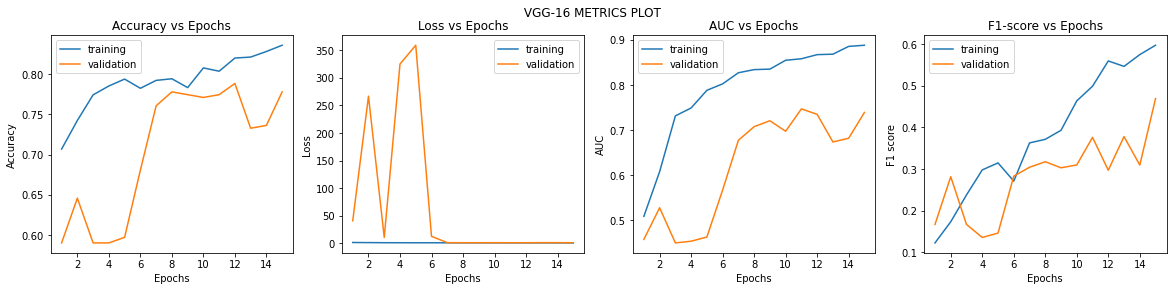

In [52]:
# PLOTTING RESULTS

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,f1,val_f1):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,4))
    fig.suptitle(" VGG-16 METRICS PLOT")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy vs Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss vs Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC vs Epochs')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(f1) + 1), f1)
    ax4.plot(range(1, len(val_f1) + 1), val_f1)
    ax4.set_title('F1-score vs Epochs')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('F1 score')
    ax4.legend(['training', 'validation'])

    plt.show()

Train_Val_Plot(vgg_model.history['accuracy'],vgg_model.history['val_accuracy'],
               vgg_model.history['loss'],vgg_model.history['val_loss'],
               vgg_model.history['auc'],vgg_model.history['val_auc'],
               vgg_model.history['f1_score'],vgg_model.history['val_f1_score']
              )